In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
import spacy
from tqdm.auto import tqdm
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import html
import unicodedata
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer  
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
df = pd.read_csv("Filter_Toxic_Comments_dataset.csv",  sep = ",", on_bad_lines='skip')

ParserError: ignored

In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


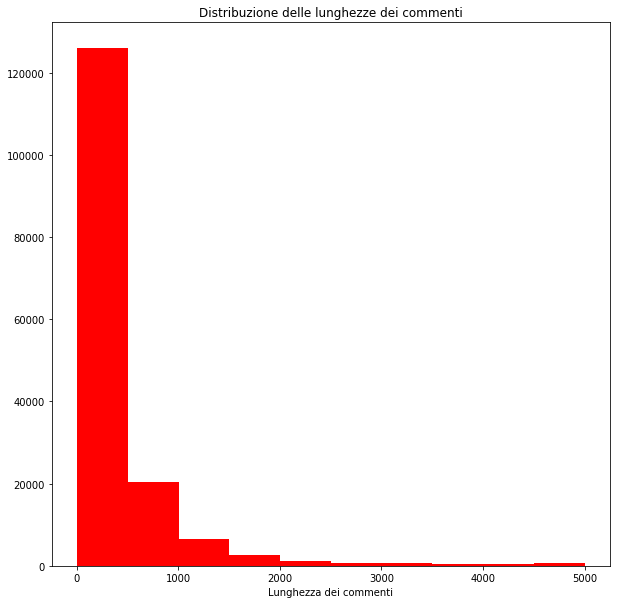

In [ ]:
plt.subplots(figsize = (10, 10))
length_sentences = [len(frase) for frase in df["comment_text"]]
plt.hist(length_sentences,10, color  = "red")
plt.xlabel('Lunghezza dei commenti')
plt.title("Distribuzione delle lunghezze dei commenti")
plt.show()

In [ ]:
val_categorie = df.drop(['comment_text'], axis=1) 
                                     
categorie = list(val_categorie.columns.values)
print(categorie)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_injurious']


Text(0.5, 0, 'Etichette delle Features')

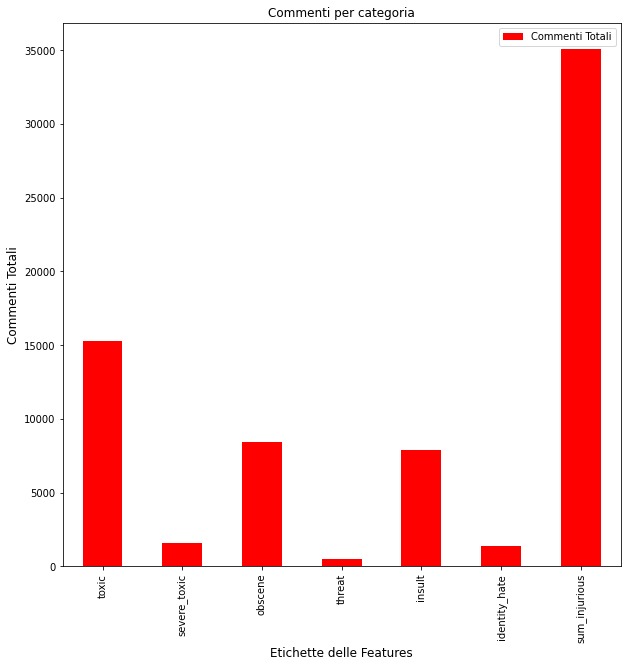

In [ ]:
features = []     
for i in categorie:
    features.append((i, val_categorie[i].sum()))
    
df_1 = pd.DataFrame(features, columns=['Etichette delle Features', 'Commenti Totali'])  
df_1.plot(x='Etichette delle Features', y="Commenti Totali", kind='bar',figsize=(10,10), sort_columns = True, color = "red")
plt.title("Commenti per categoria")
plt.ylabel('Commenti Totali', fontsize=12)
plt.xlabel('Etichette delle Features', fontsize=12)

In [ ]:
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)
def data_cleaner(sentence):
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in stop_words)
    sentence = re.sub('\d', '', sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
cleaned_sentences = list(map(lambda x: data_cleaner(x), df['comment_text']))
df['clean_text'] = cleaned_sentences

KeyboardInterrupt: ignored

In [ ]:
df.head()

In [ ]:
df = df.drop("comment_text", axis = 1)

In [ ]:
df.to_csv("dataset_toxic_cleaned.csv", sep = ";")

In [ ]:
import pandas as pd
df = pd.read_csv("dataset_toxic_cleaned.csv",  sep = ",", on_bad_lines='skip', index_col = 0)

In [ ]:
df = df.rename(columns = {"clean_comments" : "clean_text"})

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
X_train['clean_text'] = X_train['clean_text'].astype(str)
X_test['clean_text'] = X_test['clean_text'].astype(str)

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train['clean_text'])
x_train = tokenizer.texts_to_sequences(X_train['clean_text'])
x_test = tokenizer.texts_to_sequences(X_test['clean_text'])
vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

137455

In [ ]:
max_len = max([len(x) for x in x_train])

In [ ]:
len(x_train[0]), max_len

(5, 1378)

In [ ]:
padded_train = pad_sequences(x_train, maxlen=max_len - 800)
padded_test = pad_sequences(x_test, maxlen=max_len - 800)

In [ ]:
clear_session()
def get_model():
    model = models.Sequential()
    model.add(layers.Embedding(vocabulary_size, 128, input_length=max_len - 800))
    model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(layers.LSTM(32, dropout=0.2,recurrent_dropout=0.2))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(6, activation='sigmoid'))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  optimizer='adam', 
                  metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
    #tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    return model

In [ ]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 578, 128)          17594240  
                                                                 
 lstm (LSTM)                 (None, 578, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 17,656,694
Trainable params: 17,656,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class EarlyStopper(tf.keras.callbacks.Callback):
    def __init__(self, metric, threshold):
        self.metric = metric
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs, **kwargs):
        current_metric = logs[self.metric]
        print(f'epoch {epoch}, {self.metric} {current_metric}')
        if current_metric > self.threshold:
            self.model.stop_training = True
            print(f'Stopping training because {self.metric} has exceeded {self.threshold}')
threshold = 0.8
threshold_acc = 0.99
earlystopper_p = EarlyStopper(metric='precision', threshold=threshold)
earlystopper_r = EarlyStopper(metric='recall', threshold=threshold)
earlystopper_a = EarlyStopper(metric='accuracy', threshold=threshold_acc)
earlystopper_auc = EarlyStopper(metric='auc', threshold=threshold_acc)

In [ ]:
cronologia = model.fit(padded_train, X_train[['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']],
                    epochs=5, batch_size=32, validation_split=0.2,
                    callbacks = [earlystopper_p, earlystopper_r, earlystopper_auc, earlystopper_a])

Epoch 1/5
3192/3192 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9821 - auc: 0.9594 - recall: 0.5352 - precision: 0.7943epoch 0, precision 0.7942966818809509
epoch 0, recall 0.5351729393005371
epoch 0, auc 0.9594159126281738
epoch 0, accuracy 0.9820805788040161
3192/3192 [==============================] - 6358s 2s/step - loss: 0.0696 - accuracy: 0.9821 - auc: 0.9594 - recall: 0.5352 - precision: 0.7943 - val_loss: 0.0506 - val_accuracy: 0.9945 - val_auc: 0.9783 - val_recall: 0.6459 - val_precision: 0.8114
Epoch 2/5
3192/3192 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9943 - auc: 0.9838 - recall: 0.6775 - precision: 0.8181epoch 1, precision 0.8181426525115967
Stopping training because precision has exceeded 0.8
epoch 1, recall 0.6774696707725525
epoch 1, auc 0.983762800693512
epoch 1, accuracy 0.9942618608474731
Stopping training because accuracy has exceeded 0.99
3192/3192 [==============================] - 6322s 2s/step - loss: 0

In [ ]:
cronodict = cronologia.history

In [ ]:
def show_pre_results(cronologia):
    acc = round(cronodict['accuracy'][0],2)
    rec = round(cronodict['recall'][0],2)
    prec = round(cronodict['precision'][0], 2)
    loss = round(cronodict['loss'][0],2)
    auc = round(cronodict['auc'][0],2)
    val_acc = round(cronodict['val_accuracy'][0],2)
    val_loss = round(cronodict['val_loss'][0],2)
    val_rec = round(cronodict['recall'][0],2)
    val_prec = round(cronodict['precision'][0],2)
    val_auc = round(cronodict['auc'][0],2)
    return print(f"L'accuracy del modello è pari a {acc}, a fronte di una val_accuracy pari a {val_acc}.\nLa loss del modello è pari a {loss} a fronte di una val_loss pari a {val_loss}.\nLa precision del modello è pari a {prec} a fronte di una val_loss pari a {val_prec}.\nLa recall del modello è pari a {rec} a fronte di una val recall pari a {val_rec}.\nL'AUC del modello è pari a {auc} a fronte di una val auc pari a {val_auc}.")

In [ ]:
cronodict['recall'][0]

0.5351729393005371

In [ ]:
show_pre_results(cronologia)

L'accuracy del modello è pari a 0.98, a fronte di una val_accuracy pari a 0.99.
La loss del modello è pari a 0.07 a fronte di una val_loss pari a 0.05.
La precision del modello è pari a 0.79 a fronte di una val_loss pari a 0.79.
La recall del modello è pari a 0.54 a fronte di una val recall pari a 0.54.
L'AUC del modello è pari a 0.96 a fronte di una val auc pari a 0.96.


In [ ]:
def predictions(model):
    predicts = model.predict(padded_test)
    return predicts

In [ ]:
predictions=model.predict(padded_test)   
print(predictions.shape)

998/998 [==============================] - 182s 182ms/step
(31915, 6)


In [ ]:
print(predictions.shape, padded_test.shape)

(31915, 6) (31915, 578)


In [ ]:
metrics = model.evaluate(padded_test, predictions, batch_size=32, verbose=0)

In [ ]:
import numpy as np
predictions_binary = np.where(predictions > 0.001, 1, 0)
predictions_binary

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1],
       [1, 0, 1, 0, 0, 0]])

In [ ]:
predictions_binary[172] ###some try

array([1, 0, 1, 1, 1, 1])

In [ ]:
model.save('FP_model_DL_proj_V2.h5')